In [69]:
processor.pulses[0].tlist = np.array([0.1, 0.2, 0.4, 0.5])
import numpy as np
import matplotlib.pyplot as plt
import qutip
from scipy.signal.windows import dpss
from scipy.interpolate import interp1d

Two fixed frequency qubit coupled via tunable coupler ($w_{q1}-w_{q2}=constant$)
(All qubit are assumed as a perfect two level system)
## Let's make iSWAP
$$U_{iSWAP}=\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 0 & -i & 0 \\
0 & -i & 0 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}$$

from $|10>$ state to $|01> $

$$\tilde{H}(t)=g(t) 
\begin{bmatrix}
0 & 0 & 0 & 0\\
0 & 0 & e^{-i\delta \omega_{12}t} & 0 \\
0 & e^{i\delta \omega_{12}t} & 0 & 0 \\
0 & 0 & 0 & 0
\end{bmatrix}

-\frac{\Omega_1}{2}V_1S_1(t)
\begin{bmatrix}
0 & 0 & e^{i(\delta \omega_{1d}t + \phi_1)} & 0\\
0 & 0 & 0 & e^{i(\delta \omega_{1d}t + \phi_1)} \\
e^{-i(\delta \omega_{1d}t + \phi_1)} & 0 & 0 & 0 \\
0 & e^{-i(\delta \omega_{1d}t + \phi_1)} & 0 & 0
\end{bmatrix}

-\frac{\Omega_2}{2}V_2S_2(t)
\begin{bmatrix}
0 & e^{i(\delta \omega_{2d}t + \phi_2)}& 0 & 0\\
e^{-i(\delta \omega_{2d}t + \phi_2)} & 0 & 0 & 0 \\
0 & 0 & 0 & e^{i(\delta \omega_{2d}t + \phi_2)}\\
0 & 0 & e^{-i(\delta \omega_{2d}t + \phi_2)} & 0
\end{bmatrix}$$


# Setting

### Rabi oscillation frequency $\Omega$

$\Omega_1/(2\pi)=0.01$(10MHz)
$\Omega_2/(2\pi)=0.01$(10MHz)

### Qubit frequency difference $\delta \omega_{12}$
얘네가 문제임 Z line으로 control 가능하게 해야 realistic 한데

### Detuning $\delta \omega_{1}$, $\delta \omega_{2}$
$\delta \omega=\omega_q -\omega_d$


### g
$g/(2\pi)$=

### Anharmonicty $\eta$
$\eta/(2\pi)=0$ 아직 추가안함





In [70]:
def make_U(H, time_step):
    """
    PARAMETER
        Hamiltonian : function of t
        time_step : float
    RETURNS
        U : function of t
    """
    hbar = 1.
    I = np.identity(4,dtype=complex)
    
    def U(t):
        total = I #U(t=0)
        check = [I]
        times = np.arange(start=0,stop=t,step=time_step)
        for time in times:
            derivative = (-1j/hbar)*np.matmul(H(time),total)*time_step
            total = total + derivative
            check.append(total) 
        return total, np.array(check)
    return U

In [71]:
def make_H_int(g,delta_omega):
    """
    
    :param g: coupling strength
    :param detuning: omega_q1 - omega_q2
    :return: 
    """
    def H_int(t):
        matrix=np.zeros((4,4),dtype=complex)
        matrix[2][1] = np.exp((1j)*delta_omega*t)
        matrix[1][2] = np.exp((-1j)*delta_omega*t)
        return g(t)*matrix
    return H_int

In [72]:
def make_H_d1(Omega,V_0,delta_omega,phi,s):
    """
    :param Omega:  
    :param V_0: 
    :param delta_omega:omega_q - omega_d 
    :param phi: offset in driving sine wave
    :param s: control pulse
    :return: 
    """
    I=np.identity(2,dtype=complex)

    def H(t):
        matrix=np.zeros((2,2),dtype=complex)
        matrix[0][1]=np.exp((1j)*(delta_omega*t+phi))
        matrix[1][0]=np.exp((-1j)*(delta_omega*t+phi))
    
        return (-0.5)*Omega*V_0*s(t)*np.kron(matrix,I)
    
    return H #4by4 matrix

In [73]:
def make_H_d2(Omega,V_0,delta_omega,phi,s):
    """
    :param Omega:  
    :param V_0: 
    :param delta_omega:omega_q - omega_d 
    :param phi: offset in driving sine wave
    :param s: control pulse
    :return: 
    """
    I=np.identity(2,dtype=complex)
    
    def H(t):
        matrix=np.zeros((2,2),dtype='complex128')
        matrix[0][1]=np.exp((1j)*(delta_omega*t+phi))
        matrix[1][0]=np.exp((-1j)*(delta_omega*t+phi))
    
        return (-0.5)*Omega*V_0*s(t)*np.kron(I,matrix)
    
    return H #4by4 matrix

In [74]:
def g(t):
    return 0.04*2*np.pi 
# 40MHz

In [75]:
#ideal_t = np.pi / 

In [76]:
def slepian(t):
    Fs = 10 #sampling rate 1ns에 10번 
    N = 500
    time = np.arange(N+1)/Fs 
    #freq = np.fft.fftfreq(N+1,d=1/Fs)
    NW = 6    # Time-halfbandwidth product
    # Generating the Slepian sequences
    slepian_sequence = dpss(N+1, NW)
    slepian_continuous = interp1d(time, slepian_sequence, kind='cubic')
    return slepian_continuous(t)

In [77]:
#Setting
omega1 = 0.01 * 2 * np.pi #10MHz
omega2 = 0.01 * 2 * np.pi #10MHz
V1=1.
V2=1. #unit?
delta_omega1 = 0.001 * 2 * np.pi #1MHz #qubit frequency and driving frequency
delta_omega2 = 0.001 * 2 * np.pi #1MHz
delta_q12 = 1 * 2 * np.pi # 1GHz
phi1 = 0.001
phi2 = 0.001

In [78]:
H_int = make_H_int(g=g,delta_omega=0.) 
H_d1 = make_H_d1(Omega=omega1, V_0=V1,delta_omega=delta_omega1,s=slepian,phi=phi1)
H_d2 = make_H_d2(Omega=omega2, V_0=V2,delta_omega=delta_omega2,s=slepian,phi=phi2)
def H(t):
    return H_int(t)+H_d1(t)+H_d2(t)

In [79]:
U = make_U(H_int, time_step=1e-4)

In [80]:
#Uhigh = make_U(H, time_step=1e-5)

In [81]:
transition, info = U(100./16.) #한번 돌리는데 4분30초...GPU로 계산하면 더 빠른가?

In [82]:
len(info)

62501

In [83]:
#transition2, info2 = Uhigh(50.) #47분 미쳤네 

In [84]:
def get_MSE(A,B):
   return np.sum(np.square(np.abs(transition-iSWAP)))

In [85]:
initial_state = np.array([0,0,1.,0,], dtype=complex)

In [86]:
state_history=[]
for trans in info:
    tran_state=np.matmul(trans,initial_state)
    state_history.append(tran_state)

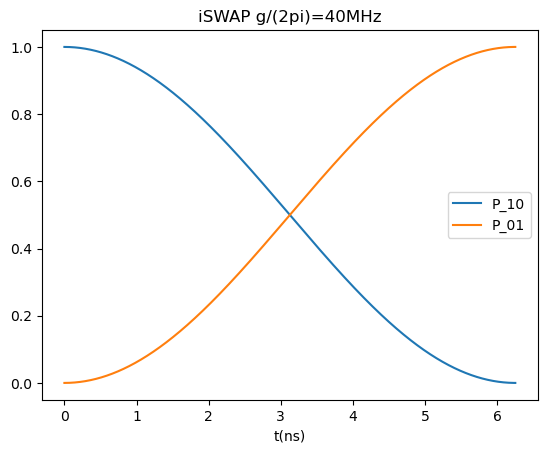

In [87]:
fig, ax = plt.subplots()
ax.set_title("iSWAP g/(2pi)=40MHz")
ax.plot(np.arange(start=0,stop=100./16.+1e-4,step=1e-4),[np.abs(s[2])**2 for s in state_history],label="P_10")
ax.plot(np.arange(start=0,stop=100./16.+1e-4,step=1e-4),[np.abs(s[1])**2 for s in state_history],label="P_01")
ax.set_xlabel("t(ns)")
plt.legend()
plt.show()

In [88]:
#prepare qubit 1 in e 
initial_state = np.array([0,0,1.,0,], dtype=complex)
desired_state = np.array([0,1.,0,0,], dtype=complex)

iSWAP=np.zeros((4,4),dtype=complex)
iSWAP[0,0]=1.
iSWAP[3,3]=1.
iSWAP[2,1]=-1j
iSWAP[1,2]=-1j


In [89]:
get_MSE(iSWAP,transition)

7.79288110212224e-10

In [90]:
error=[]
for a in [0.1,0.01,0.001]:
    H_i =make_H_int(g=g,delta_omega=a) 
    U = make_U(H_i , 1e-4)
    my_gate=U(100./16.)
    error.append(get_MSE(iSWAP, my_gate))

In [91]:
error

[7.79288110212224e-10, 7.79288110212224e-10, 7.79288110212224e-10]